### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12089
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    47|[40, 88, -128, 88...|2002.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|    28|[120, 91, 120, 91...|2003.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[16, 90, 32, 91, ...|2004.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[-104, 90, -16, 9...|2005.0|BSBSSSBS|
|     53.0| 29.9381| -82.1164|       TMAX|USC00088529|     0|[-96, 91, -48, 91...|2006.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [26]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','US1FLHB0044')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='US1FLHB0044'
5 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     17.1| 27.7057| -82.4005|       PRCP|US1FLHB0044|     0|[0, 69, 0, 0, 0, ...|2008.0|BSBSSSBS|
|     17.1| 27.7057| -82.4005|       PRCP|US1FLHB0044|     2|[0, 0, 0, 0, 0, 0...|2009.0|BSBSSSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(5, 365)

In [25]:
stations = df.select('station').distinct().collect()
print stations

[Row(station=u'USC00080598'), Row(station=u'USC00083153'), Row(station=u'US1FLPN0013'), Row(station=u'US1FLMR0003'), Row(station=u'USC00083316'), Row(station=u'US1FLHB0032'), Row(station=u'USC00087665'), Row(station=u'US1FLPS0010'), Row(station=u'US1FLHB0033'), Row(station=u'USR0000FLSU'), Row(station=u'USC00088890'), Row(station=u'US1FLHB0034'), Row(station=u'US1FLPN0016'), Row(station=u'US1FLPN0017'), Row(station=u'US1FLPN0018'), Row(station=u'US1FLHB0037'), Row(station=u'US1FLPS0015'), Row(station=u'US1FLPS0016'), Row(station=u'USW00092802'), Row(station=u'USC00085935'), Row(station=u'US1FLPS0018'), Row(station=u'USC00089176'), Row(station=u'USC00080535'), Row(station=u'USC00087395'), Row(station=u'USW00092806'), Row(station=u'USC00081310'), Row(station=u'USC00088782'), Row(station=u'USC00087440'), Row(station=u'USC00084273'), Row(station=u'USC00088786'), Row(station=u'USC00085662'), Row(station=u'USC00084327'), Row(station=u'US1FLSS0002'), Row(station=u'USC00083321'), Row(station=u

### Script for plotting yearly plots

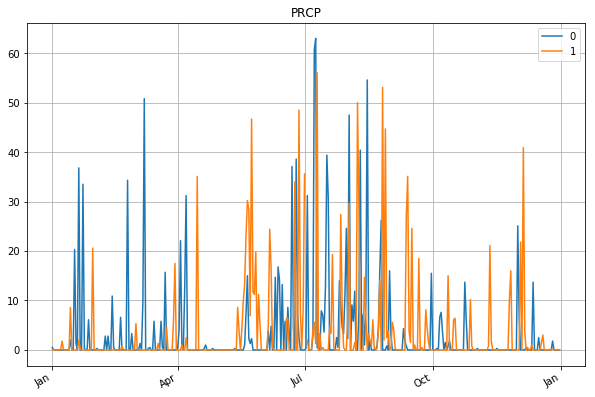

In [27]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [28]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

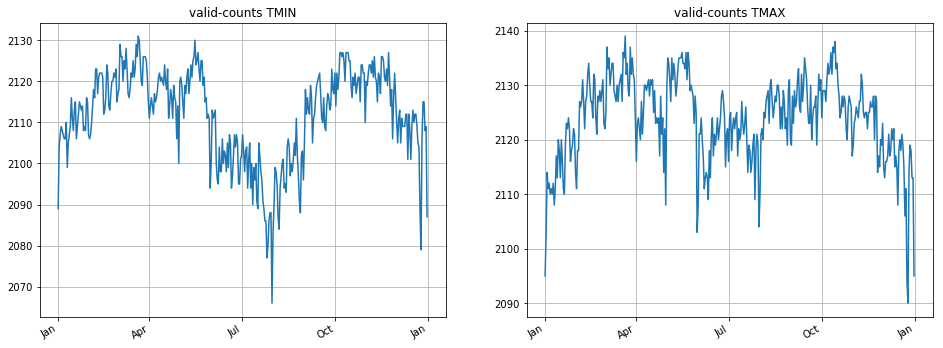

In [29]:
plot_pair(['TMIN','TMAX'],plot_valid)

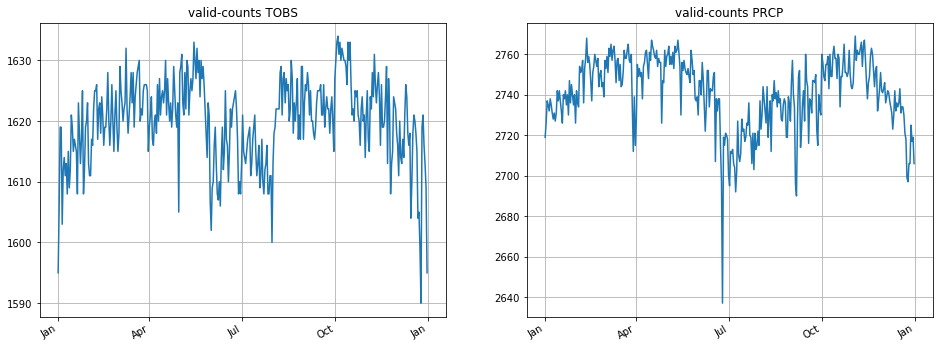

In [30]:
plot_pair(['TOBS','PRCP'],plot_valid)

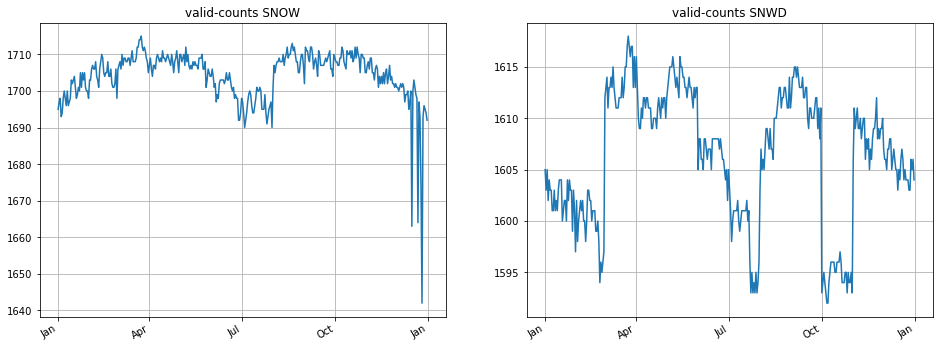

In [31]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [32]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

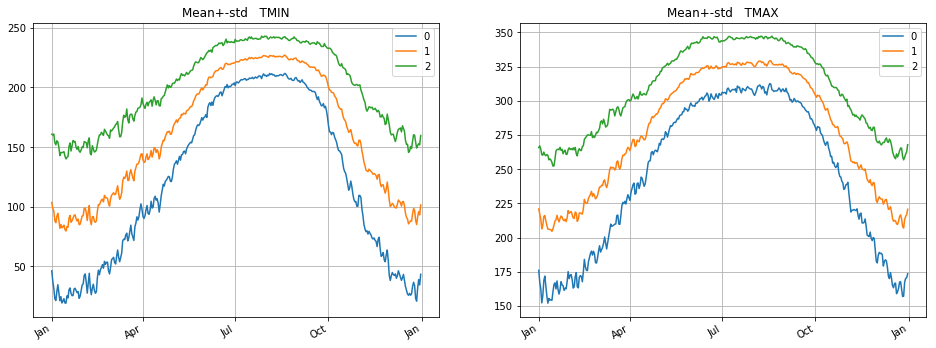

In [33]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

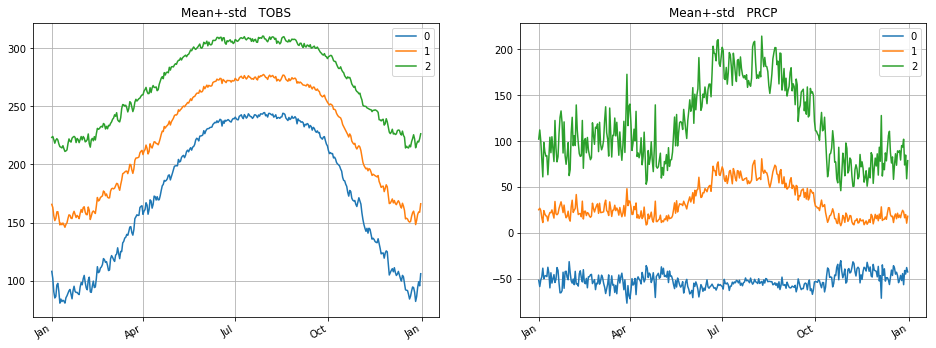

In [34]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

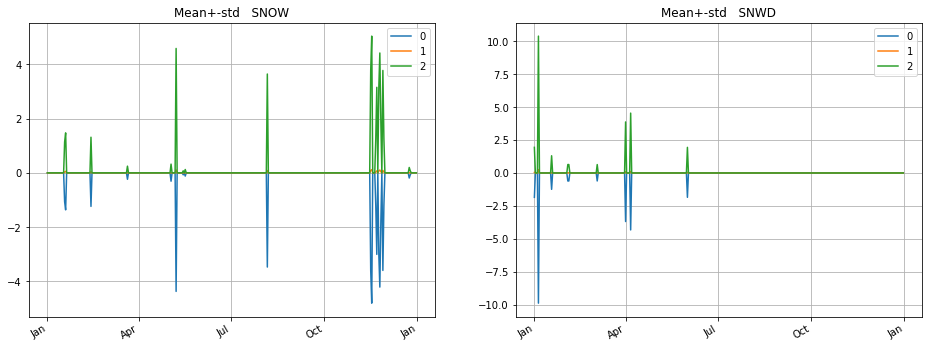

In [35]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [36]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

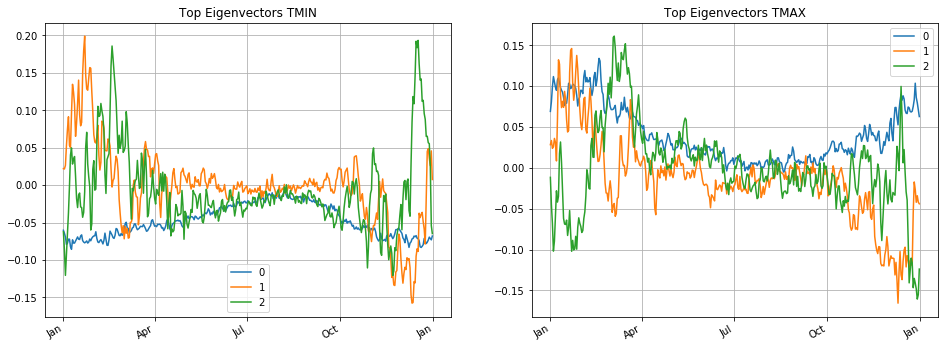

In [37]:
plot_pair(['TMIN','TMAX'],plot_eigen)

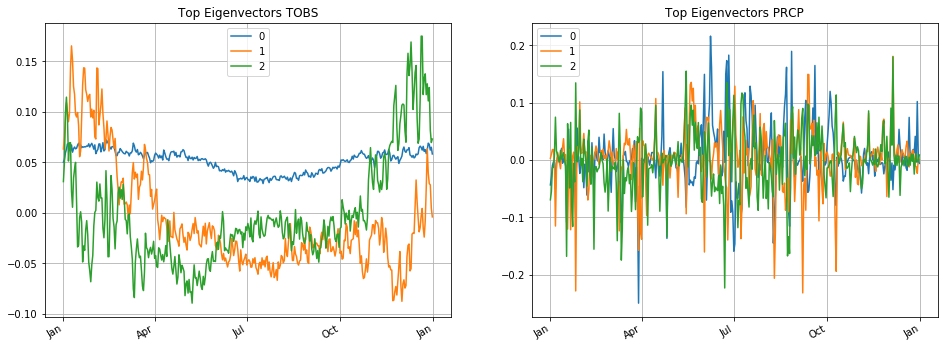

In [38]:
plot_pair(['TOBS','PRCP'],plot_eigen)

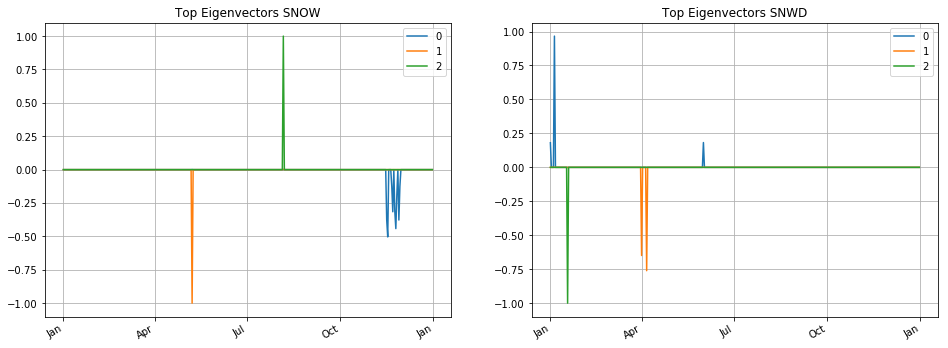

In [39]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [40]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

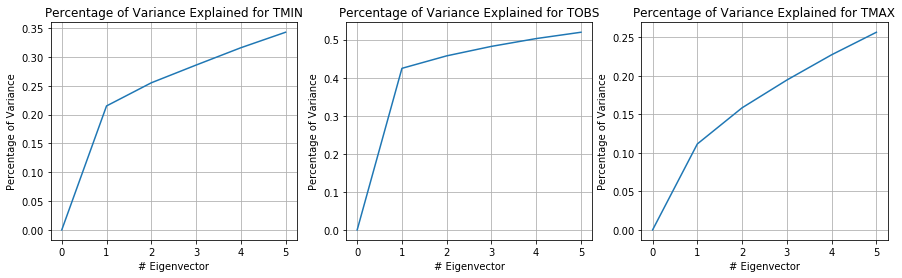

In [41]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

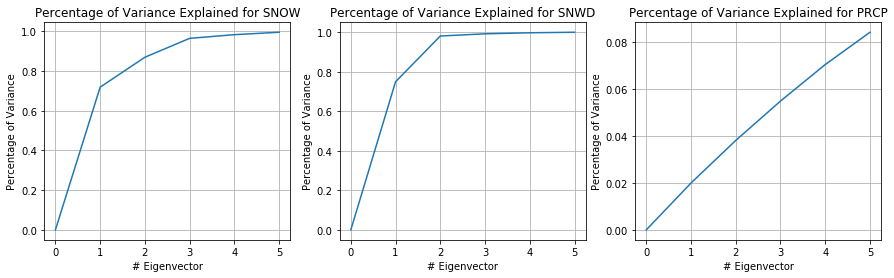

In [42]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [43]:
#sc.stop()